In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from bs4 import BeautifulSoup
from urllib.request import urlopen
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from os import path
from pymongo import MongoClient
from PIL import Image


In [22]:
urls = ['https://www1.folha.uol.com.br/banco-de-dados/2020/12/1970-zagallo-convoca-ademir-da-guia-para-a-selecao-brasileira.shtml', 
        'https://www1.folha.uol.com.br/banco-de-dados/2020/12/1970-apos-incendio-volkswagen-diz-que-volta-a-produzir-carros-em-janeiro.shtml', 
       'https://www1.folha.uol.com.br/banco-de-dados/2020/12/1970-fraude-faz-faculdade-da-santa-casa-de-sao-paulo-anular-o-vestibular.shtml', 
       'https://www1.folha.uol.com.br/banco-de-dados/2020/12/1970-volkswagen-interrompe-producao-de-carros-apos-grande-incendio.shtml', 
       'https://www1.folha.uol.com.br/banco-de-dados/2020/12/1970-grande-incendio-destroi-ala-da-volkswagen-em-sao-bernardo.shtml', 
       'https://www1.folha.uol.com.br/banco-de-dados/2020/12/1970-protestos-aumentam-e-governo-da-polonia-fala-em-utilizar-armas.shtml', 
       'https://www1.folha.uol.com.br/banco-de-dados/2020/12/1970-encarecimento-do-custo-de-vida-provoca-rebeliao-popular-na-polonia.shtml', 
       'https://www1.folha.uol.com.br/banco-de-dados/2020/12/1970-censura-federal-decide-suspender-programa-silvio-santos-da-tv-globo.shtml', 
       'https://www1.folha.uol.com.br/banco-de-dados/2020/12/1970-nos-eua-sobrevivente-do-atentado-que-matou-jfk-comandara-tesouro.shtml', 
       'https://www1.folha.uol.com.br/banco-de-dados/2020/12/1970-sem-noticia-dos-sequestradores-guanabara-vai-reforcar-seguranca.shtml']

In [24]:
#Guardando no mongo
client = MongoClient('mongodb://localhost:27017/')
database = client['avaliacao']
colecao = database['noticias']

In [25]:
#retornar titulos e parágrafos
lista = []

for url in urls:
    
    response = urlopen(url)
    html = response.read().decode('utf8')

    soup = BeautifulSoup(html, 'html.parser')
    paragrafos = soup.find('div', class_='c-news__body').findAll('p')
    titulo = soup.title.string

    paragrafos = [str(paragrafo).replace('<p>','') for paragrafo in paragrafos]
    paragrafos = [str(paragrafo).replace('</p>','') for paragrafo in paragrafos]

    lista.append({'titulo':titulo, 'conteudo':str(paragrafos)})

In [13]:
#criando df com todos os paragrafos(já retirando as tags de HTML)
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_seq_items',None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)


df = pd.DataFrame(lista)
df.head()

In [14]:
#Usando Spacy
nlp = spacy.load("pt_core_news_sm")
#gerando nlp a partir do df
doc = nlp(str(df.conteudo))

In [15]:

#definindo textos para tratamento e setando como minúsculos
textos_para_tratamento = (titulos.lower() for titulos in df["conteudo"])

In [16]:
#função de tokenização e tratativa de dados, retirando stop words/caracteres/numerais
def trata_textos(doc):
    tokens_validos = []
    for token in doc:
        e_valido = not token.is_stop and token.is_alpha
        if e_valido:
            tokens_validos.append(token.text)

    if len(tokens_validos) > 2:
        return " ".join(tokens_validos)

In [17]:
#chamando rotina para tratar todos os dados
textos_tratados = [trata_textos(doc) for doc in nlp.pipe(textos_para_tratamento, batch_size = 1000, n_process = -1)]

,titulo,conteudo,tratado
0,1970: Zagallo convoca Ademir da Guia para a seleção brasileira - 22/12/2020 - Banco de Dados - Folha,"['A CBD (Confederação Brasileira de Desportos) anunciou nesta terça-feira (22) a convocação dos 25 jogadores que defenderão a seleção brasileira na Taça Roca contra Argentina e em jogos amistosos em 1971.', 'A surpresa foi a inclusão do armador Ademir da Guia, do Palmeiras. A imprensa noticiava que o atleta era tido como vetado pelo técnico Zagallo.', 'Aos 28 anos e com um futebol de encher os olhos, parece que agora o “Divino” terá a sua definitiva chance na seleção brasileira. Com a convoc...",cbd confederação brasileira desportos anunciou convocação jogadores defenderão seleção brasileira taça roca argentina jogos amistosos surpresa inclusão armador ademir guia palmeiras imprensa noticiava atleta tido vetado técnico zagallo anos futebol encher olhos divino terá definitiva chance seleção brasileira convocação homens cbd fizeram justiça atletas chamados seleção participou copa
1,"1970: Após incêndio, Volkswagen diz que volta a produzir carros em janeiro - 21/12/2020 - Banco de Dados - Folha","['O presidente mundial da Volkswagen, Kurt Lotz, chegou ao Brasil dois dias depois do grande incêndio que destruiu uma ala da fábrica de São Bernardo do Campo (SP).', 'Após ele participar de reuniões, um balanço foi feito.', 'Os prejuízos foram calculados em Cr$ 150 milhões (o equivalente hoje a mais de R$ 1 bilhão). O valor será coberto por seguradoras.', 'A fábrica reiniciará as operações em 15 de janeiro, com a produção de 500 a 600 carros por dia. Em agosto, o número passará para 1.200.'...",presidente mundial volkswagen kurt lotz chegou brasil dias incêndio destruiu ala fábrica bernardo campo sp participar reuniões balanço feito prejuízos calculados milhões equivalente hoje bilhão será coberto seguradoras fábrica reiniciará operações janeiro produção carros dia agosto passará empresa reafirmou houve morte feridos hospitalizados grave
2,1970: Fraude faz Faculdade da Santa Casa de São Paulo anular o vestibular - 20/12/2020 - Banco de Dados - Folha,"['Com a descoberta da venda de provas e consequente quebra do sigilo das questões, a Faculdade de Ciências Médicas da Santa Casa de Misericórdia, em São Paulo, anulou os dois exames do vestibular, feitos na semana passada, e cancelou o último, que seria realizado no domingo (20).', 'Um funcionário da faculdade confessou, no Deops (Departamento Estadual de Ordem Política e Social de São Paulo), a sua participação no caso.', 'Estudantes suspeitos de terem oferecido dinheiro em troca das questõ...",descoberta venda provas consequente quebra sigilo questões faculdade ciências médicas santa casa misericórdia paulo anulou exames vestibular feitos semana passada cancelou realizado domingo funcionário faculdade confessou deops departamento estadual ordem política social paulo participação caso estudantes suspeitos terem oferecido dinheiro troca questões estavam sendo interrogados inscritos vestibular candidatos disputar vagas
3,1970: Volkswagen interrompe produção de carros após grande incêndio - 19/12/2020 - Banco de Dados - Folha,"['O incêndio na fábrica da Volkswagen em São Bernardo do Campo, na sexta-feira (18), foi considerado pelos bombeiros como um dos maiores já ocorridos na Grande São Paulo.', 'Segundo a empresa automobilística divulgou, uma pessoa morreu e duas sofreram ferimentos graves.', 'Após a grande destruição na ala 13, a mais importante na produção de veículos, a Volkswagen anunciou que espera poder reiniciar a fabricação em fevereiro, pelo menos parcialmente. Ela estava produzindo em torno de 1.000 ca...",incêndio fábrica volkswagen bernardo campo considerado bombeiros maiores ocorridos paulo empresa automobilística divulgou pessoa morreu sofreram ferimentos graves destruição ala importante produção veículos volkswagen anunciou espera reiniciar fabricação fevereiro parcialmente produzindo torno carros dia funcionários estimado entrarão férias coletivas


In [18]:
#inserindo entidade tratadas
df['tratado'] = textos_tratados
df.head()

['anunciou',
 'defenderão',
 'noticiava',
 'tido',
 'vetado',
 'encher',
 'parece',
 'terá',
 'chegou',
 'destruiu',
 'participar',
 'feito',
 'calculados',
 'coberto',
 'reiniciará',
 'passará',
 'anulou',
 'feitos',
 'cancelou',
 'realizado',
 'confessou',
 'oferecido',
 'considerado',
 'ocorridos',
 'divulgou',
 'morreu',
 'sofreram',
 'espera',
 'poder',
 'reiniciar',
 'produzindo',
 'irrompeu',
 'funcionavam',
 'atingida',
 'acabou',
 'ruindo',
 'começou',
 'trabalhavam',
 'strong',
 'publicar',
 'morrido',
 'informou',
 'provocados',
 'alastraram',
 'disse',
 'fez',
 'equivale',
 'Informou',
 'devem',
 'utilizar',
 'morreram',
 'ficaram',
 'feridas',
 'Houve',
 'começaram',
 'ganharam',
 'confirmou',
 'ocorrido',
 'responsabilizou',
 'baixou',
 'suspender',
 'aplicada',
 'tomada',
 'afirmou',
 'verificadas',
 'assumir',
 'matou',
 'houve',
 'ficou',
 'ferido',
 'governou',
 'completa',
 'aberta',
 'acentuadas',
 'ost']

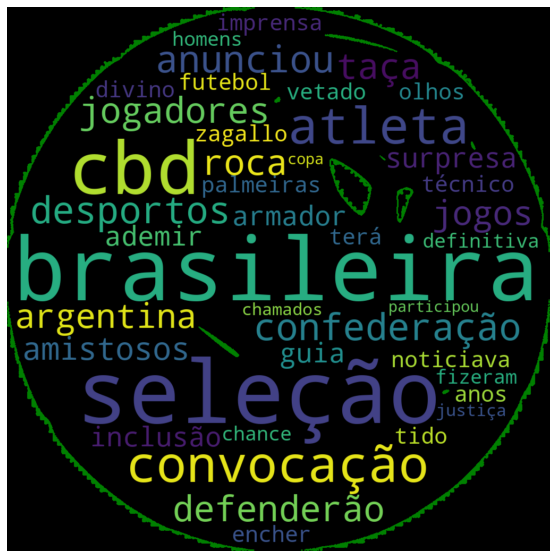

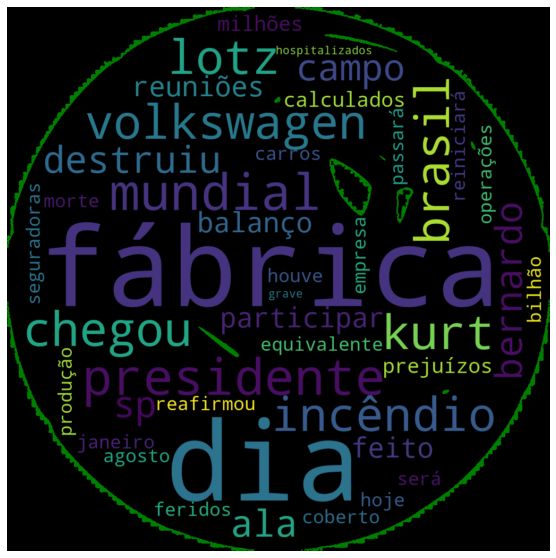

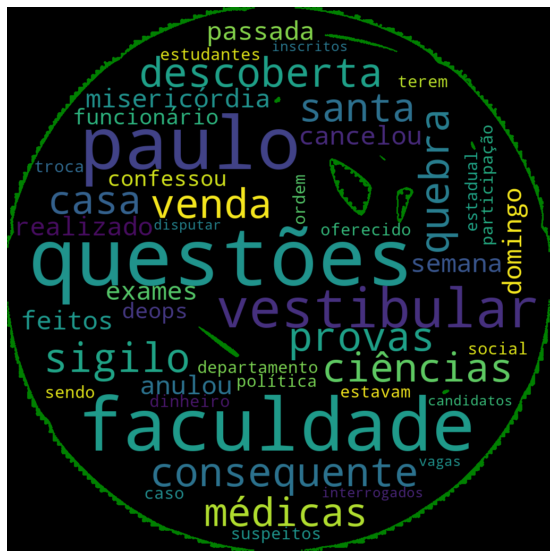

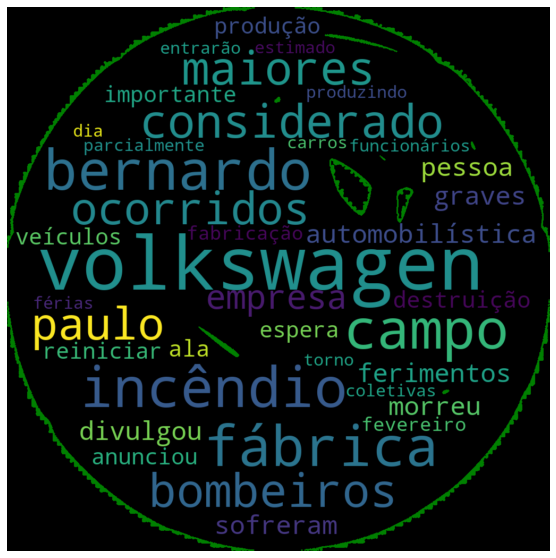

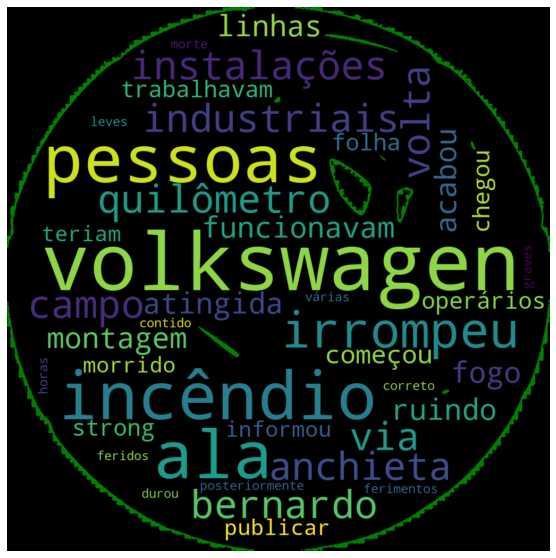

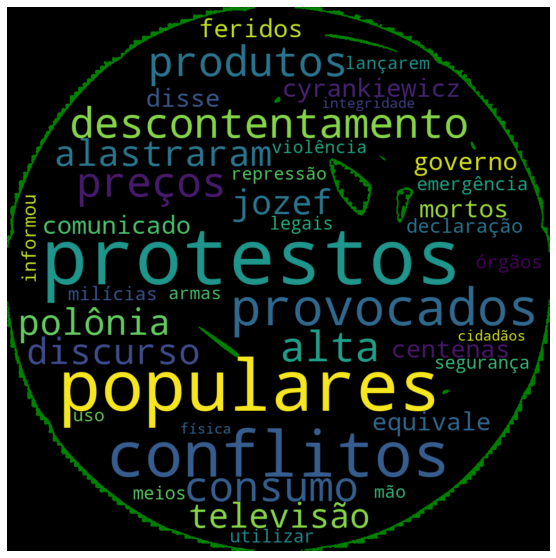

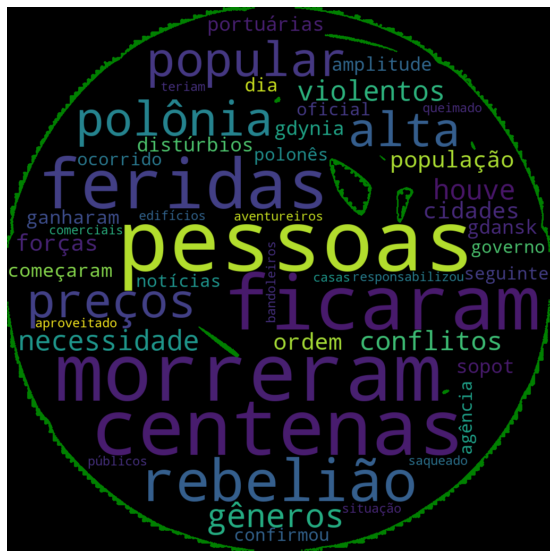

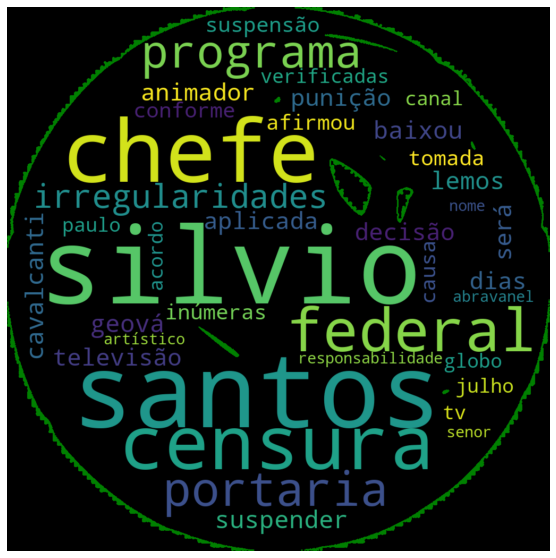

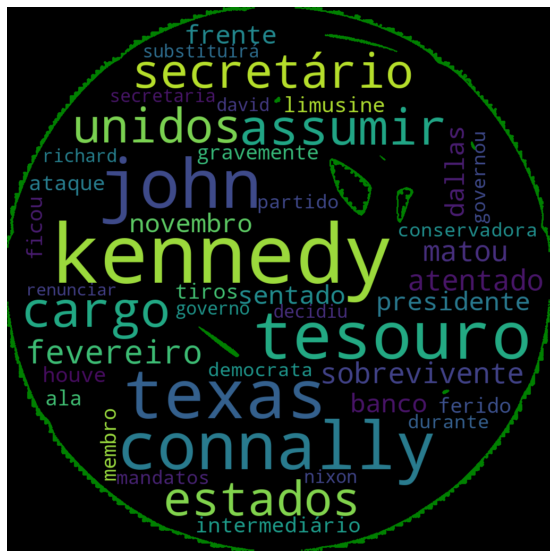

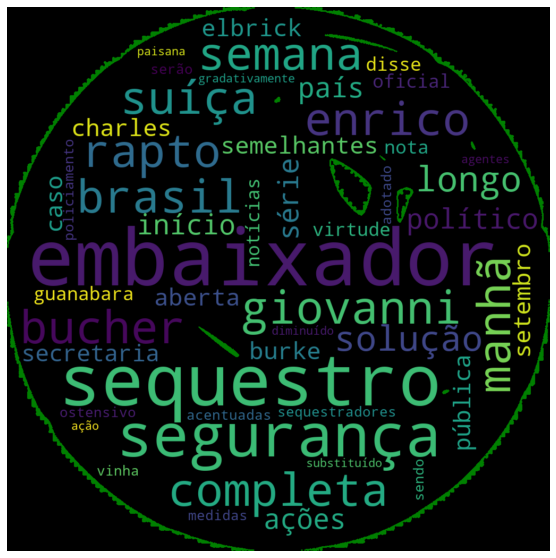

In [33]:
#gerando núvem de palavras por titulo
for i in range (0,10):
    paragrafo = str(df['tratado'][i])
    #nuvem de palavras
    todas_palavras = ''.join([texto for texto in paragrafo])

#Buscando arquivo e juntando
    twitter_mask = np.array(Image.open(path.join("Bola.jpg")))
#setando stopwords
    stopwords = set(STOPWORDS)
#Definindo modelo
    wc = WordCloud(width=800, height=500, background_color="black", max_words=2000, mask=twitter_mask, contour_width=3, contour_color='green').generate(todas_palavras)

#plotando gráfico
    plt.figure(figsize=(15, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()